## Quantifying membrane concentrations

This notebook demonstrates the code used to perform quantification of PAR protein membrane concentrations.

### Import packages

In [1]:
import sys
sys.path.append('..')
from membranequant import load_image, ImageQuant, ROI_jupyter, calc_asi, bounded_mean_1d, plot_fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Import image to quantify

Use the load_image function to import an image (tif format) as a 2D numpy array

In [2]:
# Path to embryo folder
path = '/Users/blandt/Documents/PhDWork/Code/Robustness_paper/example datasets/Example_embryo_par6_mNG_par2_mCh'

# Path to autofluorescence-corrected green channel image
path_g = path + '/af_corrected.tif'

# Path to red channel image
path_r = path + '/NEBD_Control-RNAi_02_w33-561 SP 630-75 Nelio.TIF'

# Load image
img = load_image(path_g)
# img = load_image(path_r) ## <- uncomment this line to perform quantification on red channel image instead

#### View image

<IPython.core.display.Javascript object>


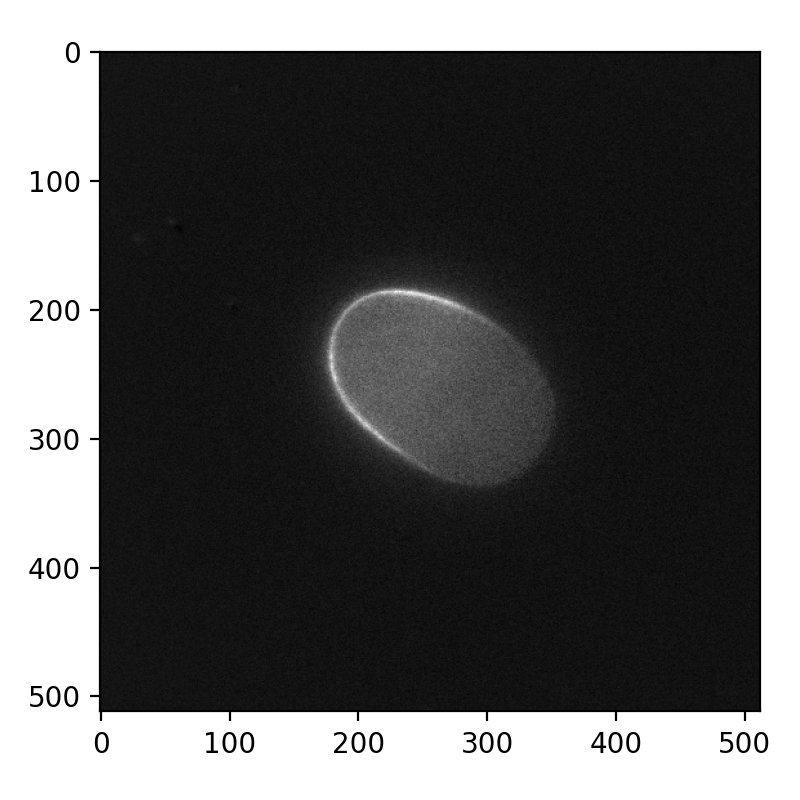

In [3]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
fig.set_size_inches(4,4)
fig.tight_layout()

### Specify ROI

Manually defining an initial ROI around the cortex, starting from the posterior. This does not need to be precise, as it will be refined by the quantifier.

You can import a pre-defined ROI (saved as a txt file), or maunally define one here (see below)

<IPython.core.display.Javascript object>


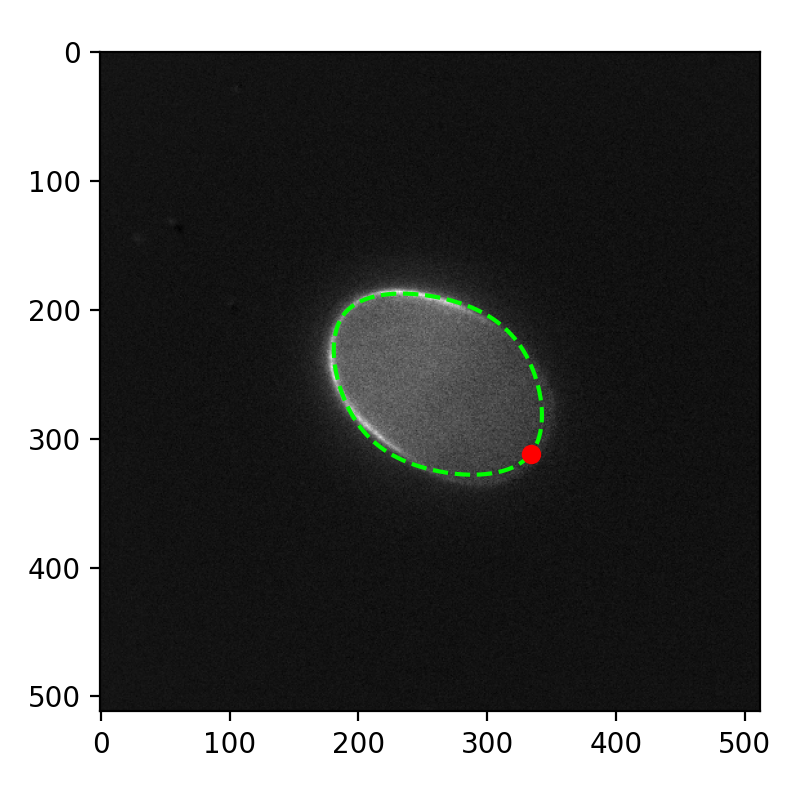

In [4]:
roi = np.loadtxt(path + '/ROI.txt') # loading pre-defined ROI

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.plot(roi[:, 0], roi[:, 1], c='lime', linestyle='--')
ax.scatter(roi[0, 0], roi[0, 1], c='r', zorder=10)
fig.set_size_inches(4,4)
fig.tight_layout()

To manually select an ROI, uncomment the next two cells and follow the onscreen instructions

In [5]:
# roi = None
# roi_tool = ROI_jupyter(img)
# roi_tool.run()

In [6]:
# roi = roi_tool.roi
# print(roi) # If this prints None, you might have forgotten to press Save above!

### ImageQuant class

Membrane quantification will be handled by the ImageQuant class. This works by straightening the cortex according to the user defined ROI, and fitting each position around the cortex independently to the sum of a Gaussian function (representing membrane signal) and an error function (representing cytoplasmic signal). These fits are then used to refine the initial ROI and restraighten the cortex, and fitting is then repeated. Membrane signal at each position is given as the amplitude of the Gaussian component.

Uses a differential evolution algorithm (scipy) to perform fitting. For more details, see the quantification.py file in the membranequant package.

In [7]:
help(ImageQuant)

Help on class ImageQuant in module membranequant.quantification:

class ImageQuant(builtins.object)
 |  ImageQuant(img, sigma=None, roi=None, freedom=0.5, periodic=True, thickness=50, itp=10, rol_ave=10, parallel=False, cores=None, rotate=False, zerocap=True, nfits=None, iterations=2, interp='cubic', save_path=None, bg_subtract=False)
 |  
 |  Quantification works by taking cross sections across the membrane, and fitting the resulting profile as the sum of
 |  a cytoplasmic signal component and a membrane signal component
 |  
 |  Input data:
 |  img                image
 |  roi                coordinates defining cortex
 |  
 |  Fitting parameters:
 |  sigma              gaussian/error function width
 |  freedom            amount of freedom allowed in ROI (0=min, 1=max, max offset is +- 0.5 * freedom * thickness)
 |  periodic           True if coordinates form a closed loop
 |  thickness          thickness of cross section over which to perform quantification
 |  itp                am

### Perform membrane quantification

Perform quantification using the ImageQuant class. This will save quantification results in the folder specified below (save_path).

In [8]:
# Specify path to save results
save_path = path + '/Quantification'

# Set up class
q = ImageQuant(img=img, roi=roi, sigma=2, thickness=50, rol_ave=20, parallel=False, freedom=0.5,
                nfits=100, save_path=save_path, bg_subtract=True)

# Run quantification
q.run()

#### Monitor quality of the fits

Scan along the straightened cortex and compare the actual cross-cortex profiles to model fits. Make sure this looks reasonable.

<IPython.core.display.Javascript object>


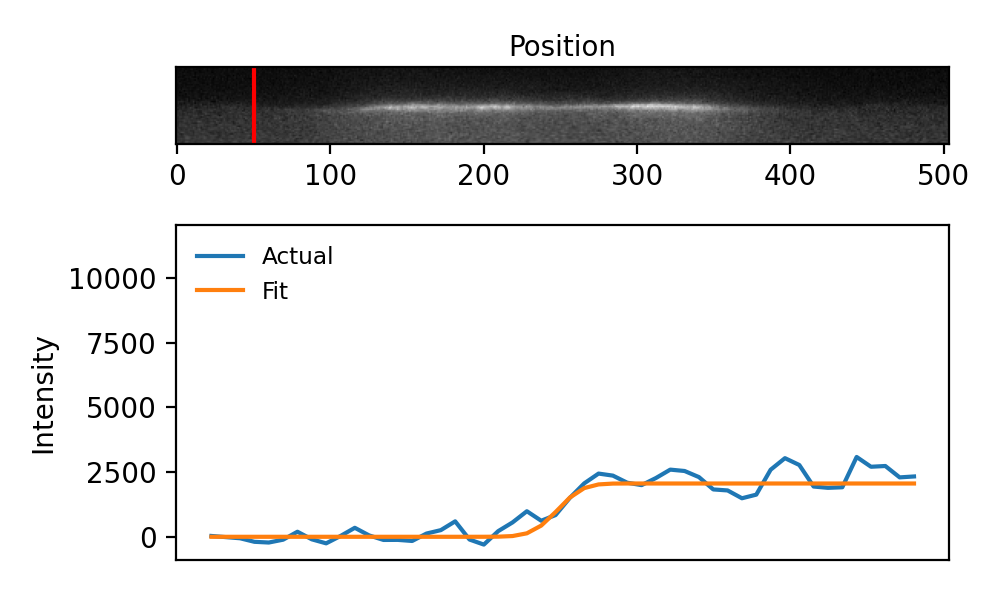

interactive(children=(FloatSlider(value=0.1, description='Position', max=1.0, step=0.01), Output()), _dom_clas…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [9]:
target = load_image(save_path + '/straight.tif')  # straightened cortex (ground truth) saved in save_path
fit = load_image(save_path + '/straight_fit.tif')  # straightened cortex (model fit) saved in save_path
plot_fits(target, fit)

### Plot quantification results

Plot membrane concentration around the circumference of the embryo, from posterior to anterior, back to posterior.

<IPython.core.display.Javascript object>


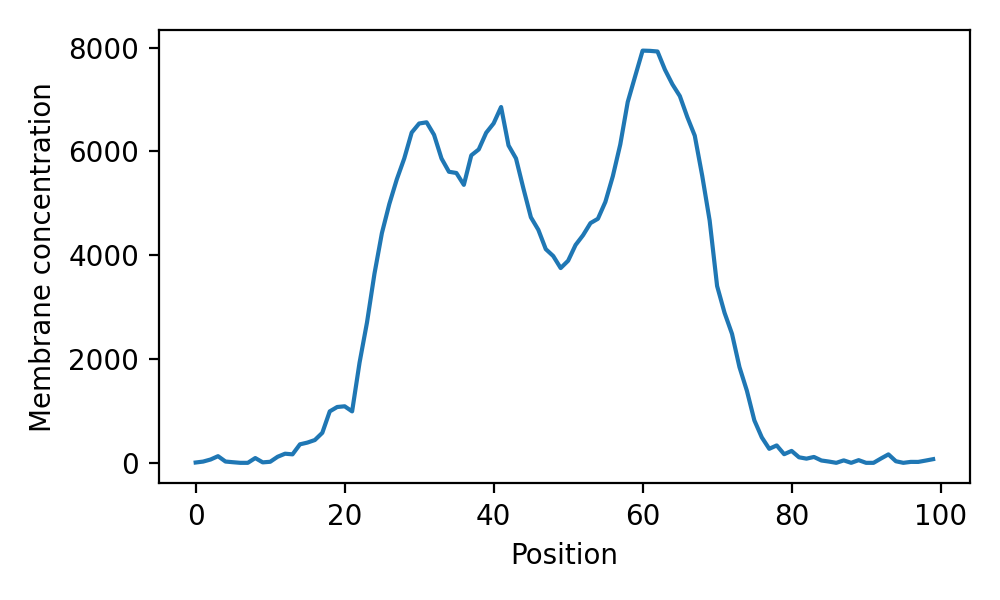

In [10]:
mems = np.loadtxt(save_path + '/mems.txt')  # membrane quantification saved as a txt file in save_path

fig, ax = plt.subplots()
ax.plot(mems)
ax.set_xlabel('Position')
ax.set_ylabel('Membrane concentration')
fig.set_size_inches(5, 3)
fig.tight_layout()

### Further analysis

#### Asymmetry index (ASI)

In [11]:
asi = abs(calc_asi(mems))
print('ASI = %.2f' % asi)

ASI = 0.49


#### Mean anterior and posterior concentrations

In [12]:
ant = bounded_mean_1d(mems, (0.33, 0.67))
print('Anterior concentration = %.2f' % ant)

post = bounded_mean_1d(mems, (0.83, 0.17))
print('Posterior concentration = %.2f' % post)

Anterior concentration = 5828.57
Posterior concentration = 94.59
